In [26]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the training data into feature matrix, class labels, and event ids:

In [27]:
from proj1_helpers import *
#Change the path according to where is your data 
DATA_TRAIN_PATH = "C:\\Users\\Asus-PC\\Desktop\\ML\\Project1\\data\\train.csv" 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

# Data Pre-Processing

In [28]:
k = np.zeros(3).reshape(-1,1)
kk = np.array([3,3,3]).reshape(-1,1)

In [29]:
### Transform tX by changing -999 with the mean of column
def transformTX(tX):
    tX2 = np.copy(tX)
    tX2[tX2 == -999] = 0
    means = np.mean(tX2, axis=0)
    for i in range(tX.shape[0]):
        for j in range(tX.shape[1]):
            if tX[i][j] == -999:
                tX[i][j] = means[j]
    return tX

def maybeAddLog(tX):
    tX2 = np.copy(tX)
    mins = np.min(tX2, axis=0)
    for i in range(tX.shape[1]):
        if mins[i]>0:
            for k in range(tX.shape[0]):
                tX[k][i] = np.log(tX[k][i])
    return tX

def normalizeData(tX):
    return (tX - np.mean(tX))/np.std(tX)

def featuresExpansion(tX, degree):
    res = np.zeros(tX.shape[0]).reshape(-1,1)
    for i in range(tX.shape[1]):
        for d in range(1,degree+1):
            col = tX[:,i]**d
            col = col.reshape(-1,1)
            res = np.hstack((res, col))
    res = np.delete(res, 0,1)
    return res
            
tX = transformTX(tX)
tX = maybeAddLog(tX)
deg = 6
tX = featuresExpansion(tX, deg)

# Linear Regression

Remark: We are assuming that we DO NOT have an offset and that w = {w1, w2, ... , wD} where D=30 in our case

In [30]:
### Helper function to select a small set of data (Given in lab2)
def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """
    Generate a minibatch iterator for a dataset.
    Takes as input two iterables (here the output desired values 'y' and the input data 'tx')
    Outputs an iterator which gives mini-batches of `batch_size` matching elements from `y` and `tx`.
    Data can be randomly shuffled to avoid ordering in the original data messing with the randomness of the minibatches.
    """
    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_tx = tx
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]

In [31]:
### Loss function that we use (this function is not used directly but only its gradient)
def compute_loss_lin(y, tX, w):
    #Calculate the loss using mse
    N = y.shape[0]
    e = y - (tX @ w)
    return (1/(2*N)) * (e.T @ e)

In [32]:
### Compute the gradient
def compute_gradient_lin(y, tX, w):
    e = y - (tX @ w)
    return (-1/N) * (tX.T @ e)

In [33]:
### Gradient descent algorithm: the function returns best w
def least_squares_GD(y, tX, initial_w, max_iters, gamma):
    w = initial_w
    for n_iter in range(max_iters):
        grad = compute_gradient_lin(y,tX,w)
        w = w - gamma * grad
    return w

In [34]:
### Stochastic gradient descent algorithm: the function returns best w
def least_squares_SGD(y, tX, initial_w, max_iters, gamma):
    batch_size = 1
    iterate = next(batch_iter(y, tX, batch_size, num_batches=1, shuffle=True))
    y1 = iterate[0]
    tX1 = iterate[1]
    w = initial_w
    for n_iter in range(max_iters):
        grad = compute_gradient_lin(y1,tX1,w)
        w = w - gamma * grad
    return w

In [35]:
### Least squares regression using normal equations
def least_squares(y, tX):
    return np.linalg.solve(tX.T@tX,tX.T@y)

# Ridge Regression

In [36]:
### Ridge regression using normal equations 
def ridge_regression(y, tx, lambda_):
    N = np.shape(tx)[0]
    D = np.shape(tx)[1] 
    lambda_prime = 2 * N * lambda_
    identity = np.eye(D)
    LHS = (tx.T@tx) + lambda_prime*identity
    RHS = tx.T@y
    
    return np.linalg.solve(LHS, RHS)

# Logistic Regression

In [37]:
### Helper function to compute sigmoid
def sigmoid(t):
    """apply sigmoid function on t."""
    return 1.0 / (1 + np.exp(-t))

In [38]:
def compute_logistic_loss(y, tx, w):
    """compute the cost by negative log likelihood."""
    val = y.T @ np.log(sigmoid(tx@w)) + (1-y.T) @ np.log(1-sigmoid(tx@w))
    return np.squeeze(- val)

In [39]:
### Compute the gradient of  
def compute_gradient_log(y, tx, w):
    return tx.T @ (sigmoid(tx@w) - y)

In [40]:
### Logistic regression using gradient descent
def logistic_regression_GD(y, tx, initial_w, max_iters, gamma):
    w = initial_w
    for _ in range(max_iters):
        gradient = compute_gradient_log(y, tx, w)
        w = w - gamma * gradient
    
    return w

In [41]:
### Logisitic regression using stochastic gradient descent 
def logistic_regression_SGD(y, tx, initial_w, max_iters, gamma):
    batch_size = 1
    iterate = next(batch_iter(y, tx, batch_size, num_batches=1, shuffle=True))
    y1 = iterate[0]
    tx1 = iterate[1]
    w = initial_w
    
    for _ in range(max_iters):
        gradient = compute_gradient_log(y1, tx1, w)
        w = w - gamma * gradient
        
    return w    

# Regularized Logistic Regression

In [42]:
### Compute regularized gradient
def compute_gradient_reg(y, tx, w, lambda_):
    return compute_gradient_log(y, tx, w) + lambda_*w

In [43]:
### Regularized Logistic regression using gradient descent
def reg_logistic_regression_GD(y, tx, lambda_, initial_w, max_iters, gamma):
    w = initial_w
    for _ in range(max_iters):
        gradient = compute_gradient_reg(y, tx, w, lambda_)
        w = w - gamma * gradient
    return w

In [44]:
### Regularized Logisitic regression using stochastic gradient descent 
def reg_logistic_regression_SGD(y, tx, lambda_, initial_w, max_iters, gamma):
    batch_size = 1
    iterate = next(batch_iter(t, tx, batch_size, num_batches=1, shuffle=True))
    y1 = iterate[0]
    tx1 = iterate[1]
    w = initial_w
    
    for _ in range(max_iters):
        gradient = compute_gradient_reg(y1, tx1, w, lambda_)
        w = w - gamma * gradient
        
    return w 

# Prediction logistic regression

In [45]:
def predict_labels_logistic(weights, data):
    """Generates class predictions given weights, and a test data matrix on a logistic regression"""
    y_pred = np.dot(data, weights)
    for i in range(len(y_pred)):
        y_pred[i] = sigmoid(y_pred[i])
    y_pred[np.where(y_pred < 0.5)] = -1
    y_pred[np.where(y_pred >= 0.5)] = 1
    
    return y_pred

# Cross validation

In [46]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

In [47]:
def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # get k'th subgroup in test, others in train
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    y_te = y[te_indice]
    y_tr = y[tr_indice]
    x_te = x[te_indice]
    x_tr = x[tr_indice]
    # logistic regression
    w = ridge_regression(y, tX, lambda_)
    # calculate the loss for train and test data
    loss_tr = compute_loss_lin(y_tr, x_tr, w)
    loss_te = compute_loss_lin(y_te, x_te, w)
    return loss_tr, loss_te, w

0.0001
0.28760338021392357


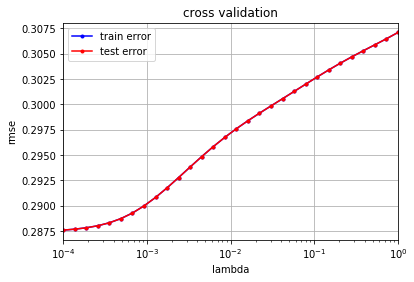

In [48]:
from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 6
    degree = 7 #Doesn't matter
    k_fold = 6
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # cross validation
    minimum = 100
    mlambda = 0
    for lambda_ in lambdas:
        rmse_tr_tmp = []
        rmse_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te,_ = cross_validation(y, tX, k_indices, k, lambda_, degree)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
        rmse_tr.append(np.mean(rmse_tr_tmp))
        rmse_te.append(np.mean(rmse_te_tmp))
        if np.mean(rmse_te_tmp) < minimum :
            minimum = np.mean(rmse_te_tmp)
            mlambda = lambda_

    cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    print(mlambda)
    print(minimum)
cross_validation_demo()

# Generate predictions and save ouput in csv format for submission:

In [49]:
DATA_TEST_PATH = 'C:\\Users\\Asus-PC\\Desktop\\ML\\Project1\\data\\test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
##WE ALSO TRANSFORM TX_TEST
tX_test = transformTX(tX_test)
tX_test = maybeAddLog(tX_test)
tX_test = featuresExpansion(tX_test, deg)

In [50]:
OUTPUT_PATH = 'C:\\Users\\Asus-PC\\Desktop\\output.csv' # TODO: fill in desired name of output file for submission

###COMMENT ONE OF THE IFs

###IF WE ARE USING LEAST_SQUARES 
weights = least_squares(y,tX)
y_pred = predict_labels(weights, tX_test)

###IF WE ARE USING LOGISTIC REGRESSION
# y[y == -1] = 0  #We set y's where it is -1 to 0 in order to work with probabilities
# D = tX.shape[1]
# initial_w = np.random.randint(-1000, 1000, D)
# print(initial_w)
# max_iters = 1000
# gamma = 1e-10
# weights = logistic_regression_GD(y, tX, initial_w, max_iters, gamma)
# y_pred = predict_labels_logistic(weights, tX_test)

#Create submission
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)